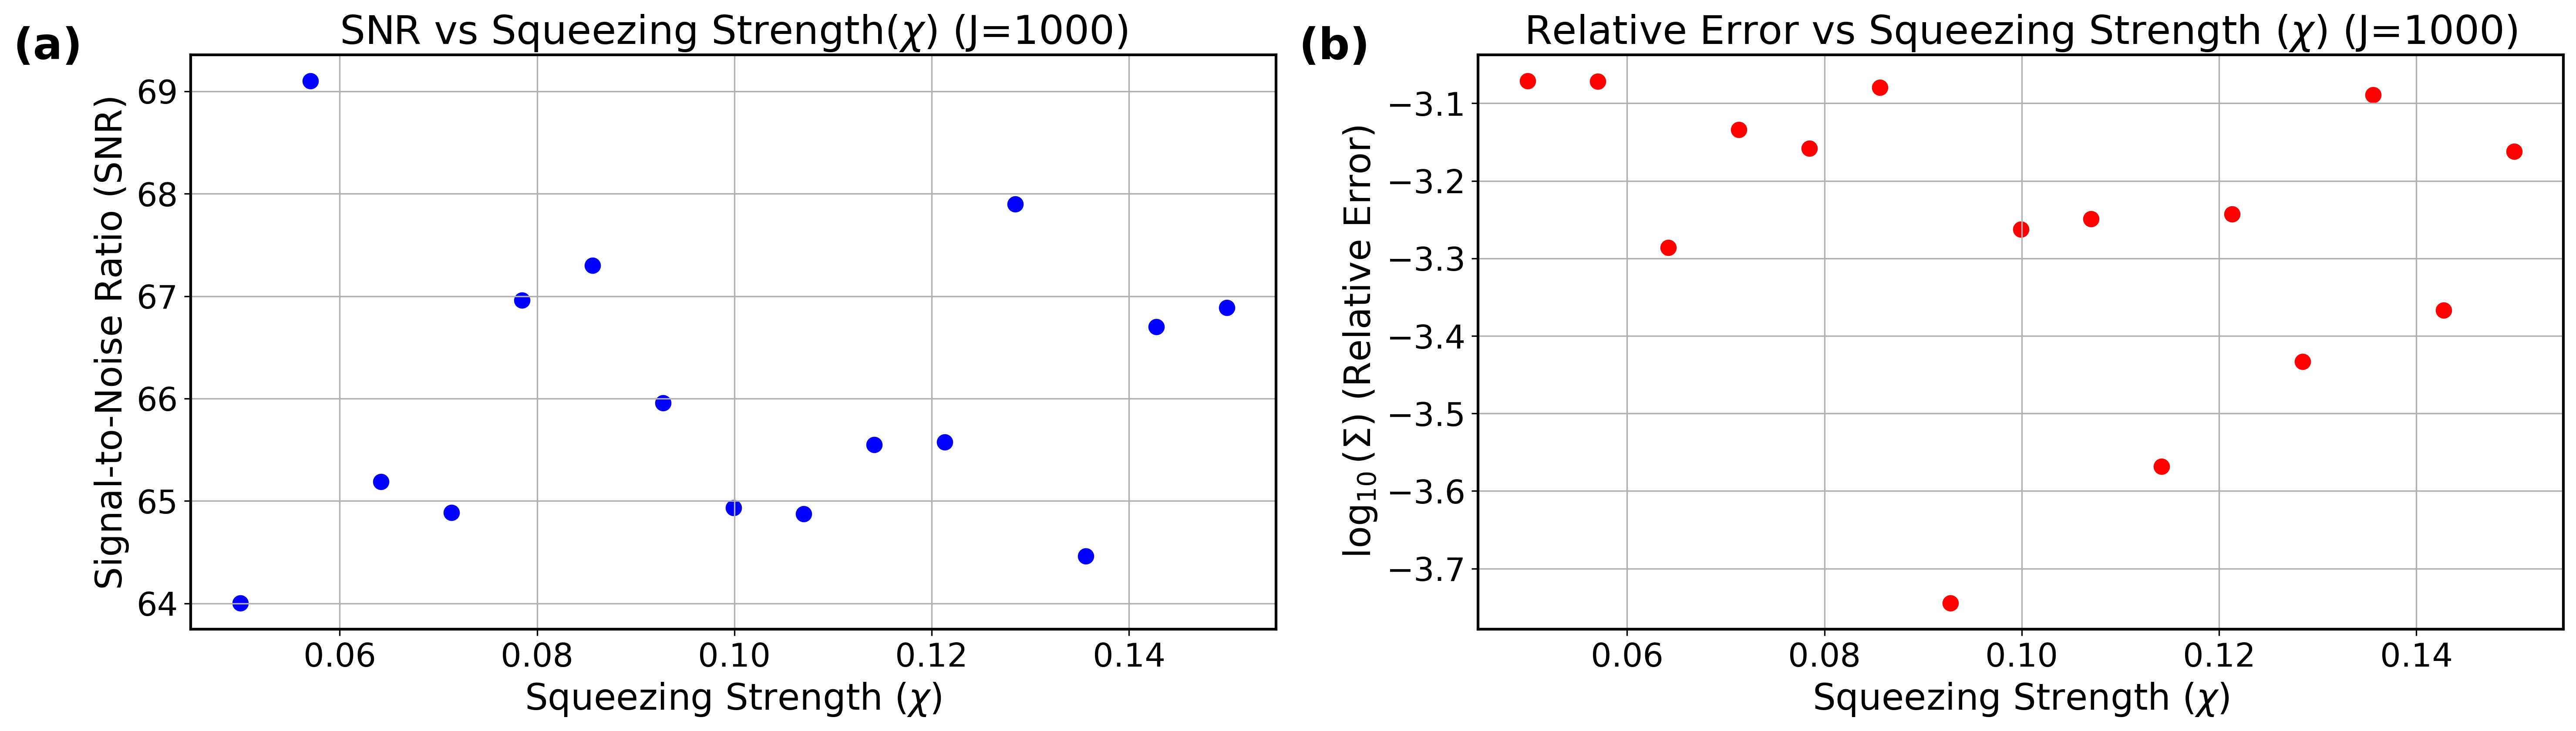


--- Statistical Summary ---
Number of Data Points: 15
Mean SNR: 66.0187
Standard Deviation of SNR: 1.3698
Minimum SNR: 64.0027
Maximum SNR: 69.1010
Mean Relative Error: 5.9401e-04
Standard Deviation of Relative Error: 2.0607e-04
Minimum Relative Error: 1.8006e-04
Maximum Relative Error: 8.4892e-04
Minimum squeezing strength: 4.9900e-02


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.signal.windows import blackmanharris
from fractions import Fraction
import os
from joblib import Parallel, delayed
import multiprocessing

# -------------------------------
# 1. Configuration and Setup
# -------------------------------

# Create a directory to save the plots
output_dir = 'pareto_plots'
os.makedirs(output_dir, exist_ok=True)

# Update plotting parameters for better aesthetics
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# -------------------------------
# 2. Define Constants and Parameters
# -------------------------------

# Constants
omega_0 = 1.0
np_val = 4.0
omega_est = omega_0
ns = 30
nspad = 1000

# Squeezing parameters
chi_central = 0.0999
chi_values = np.linspace(chi_central - 0.05, chi_central + 0.05, 15)  # Chi values around the central point
J_values = [1000]

# Seed for reproducibility
np.random.seed(37)

# Parameters for noise
sigma = 0.03 * omega_0  # 3% of omega_0
dsn = 10000  # Adjusted for faster execution

# Central values for alpha and beta
fixed_alpha = 4.8644
fixed_beta = 0.6081

# -------------------------------
# 3. Define the Expectation Function
# -------------------------------

def jalphabeta(alpha, beta, chi, omega, t, J):
    """
    Computes the expectation value based on the given parameters.
    """
    return J * np.sin(beta) * (np.cos(chi) ** (2 * J - 1)) * np.cos(alpha - omega * t)

# -------------------------------
# 4. Define the FFT Function with Padding
# -------------------------------

def gfft_sig(chi, omega_0, alpha, beta, np_val, omega_est, ns, nspad, J):
    """
    Performs BMH FFT on the padded data and returns the frequency and power spectrum.
    """
    T_max = np_val * (2 * np.pi) / omega_est
    delta_t = (np_val / (ns - 1)) * (2 * np.pi) / omega_est
    time_sampling = np.linspace(0, T_max, ns)

    # Generate Blackman-Harris window
    window = blackmanharris(ns)

    # Data calculation with window applied
    data = np.array([jalphabeta(alpha, beta, chi, omega_0, t, J) for t in time_sampling]) * window

    # Zero-padding
    data_padded = np.pad(data, (0, nspad - len(data)), 'constant')
    spectrum_length = len(data_padded) // 2
    freq_range = (2 * np.pi) / ((nspad - 1) * delta_t) * np.arange(spectrum_length)
    fft_data = np.abs(fft(data_padded))[:spectrum_length] ** 2
    return np.column_stack((freq_range, fft_data))

# -------------------------------
# 5. Define the FFT Data Generation Function
# -------------------------------

def data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn):
    """
    Generates FFT data with added noise.
    """
    delta_omega = np.random.normal(0, sigma, dsn)
    fft_results = []
    for delta in delta_omega:
        current_omega = omega_0 + delta
        fft_result = gfft_sig(chi, current_omega, alpha, beta, np_val, omega_est, ns, nspad, J)
        fft_results.append(fft_result)
    return fft_results

# -------------------------------
# 6. Define the Processing Function for Each Parameter Combination
# -------------------------------

def process_combination(J, chi, alpha, beta):
    """
    Processes a single combination of parameters:
    - Generates FFT data with noise.
    - Computes SNR and Relative Error.
    Returns the results or None if an error occurs.
    """
    try:
        # Generate FFT data with noise
        fft_data = data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn)
        
        # Convert list of arrays to 2D array: (dsn, spectrum_length, 2)
        fft_array = np.array(fft_data)  # Shape: (dsn, spectrum_length, 2)
        
        # Extract frequency and power
        freq_values = fft_array[0, :, 0]  # Frequencies are same across all FFTs
        power_values = fft_array[:, :, 1]  # Shape: (dsn, spectrum_length)
        
        # Calculate average and standard deviation across dsn
        fft_avg = np.mean(power_values, axis=0)  # Shape: (spectrum_length,)
        fft_stddev = np.std(power_values, axis=0)  # Shape: (spectrum_length,)
        
        # Interpolation to find max peak of fft_avg
        fft_avg_interp = interp1d(freq_values, fft_avg, kind='cubic', bounds_error=False, fill_value=0)
        max_peak_freq = minimize_scalar(lambda x: -fft_avg_interp(x),
                                        bounds=(freq_values[0], freq_values[-1]),
                                        method='bounded').x
        
        # Interpolation of SNR data
        with np.errstate(divide='ignore', invalid='ignore'):
            snr_data = np.divide(fft_avg, fft_stddev, out=np.zeros_like(fft_avg), where=fft_stddev != 0)
        snr_interp = interp1d(freq_values, snr_data, kind='cubic', bounds_error=False, fill_value=0)
        max_snr = snr_interp(max_peak_freq)
        
        # Relative Error in Frequency
        relative_error_freq = np.abs(1 - (max_peak_freq / omega_0))
        
        # Store actual alpha and beta (not normalized)
        alpha_actual = alpha  # 0 to 2pi
        beta_actual = beta    # 0 to pi
        
        return (J, chi, alpha_actual, beta_actual, max_snr, relative_error_freq)
    
    except Exception as e:
        print(f"Error processing J={J}, chi={chi}, alpha={alpha}, beta={beta}: {e}")
        return None

# -------------------------------
# 7. Define the Chi Variation Processing Function (Selecting Lowest Error)
# -------------------------------

def process_chi_variation_lowest_error(J, alpha_central, beta_central, num_points=3):
    """
    Processes the variation of chi around a central value and finds combinations that yield the lowest relative error.
    """
    results = []
    
    # Use joblib to parallelize the chi variation processing
    num_cores = multiprocessing.cpu_count()
    all_results = Parallel(n_jobs=num_cores)(
        delayed(process_alpha_beta_for_chi)(J, chi, alpha_central, beta_central, num_points) for chi in chi_values
    )

    # Select the result with the lowest relative error for each chi
    for chi_results in all_results:
        if chi_results:
            lowest_error_result = min(chi_results, key=lambda x: x[5])
            results.append(lowest_error_result)

    return results

# Helper function to process alpha-beta combinations for a given chi value

def process_alpha_beta_for_chi(J, chi, alpha_central, beta_central, num_points):
    """
    Processes alpha and beta variations for a fixed chi value.
    """
    alpha_variation = np.linspace(alpha_central - 0.05, alpha_central + 0.05, num_points)
    beta_variation = np.linspace(beta_central - 0.05, beta_central + 0.05, num_points)
    
    # Generate all combinations of alpha and beta for the given chi
    alpha_beta_combinations = [(J, chi, alpha, beta) for alpha in alpha_variation for beta in beta_variation]

    # Use joblib to parallelize the processing of combinations
    num_cores = multiprocessing.cpu_count()
    chi_results = Parallel(n_jobs=num_cores)(
        delayed(process_combination)(*comb) for comb in alpha_beta_combinations
    )
    
    # Filter out None results due to exceptions
    return [res for res in chi_results if res is not None]

# -------------------------------
# 8. Define the Chi Variation Plot Function
# -------------------------------

def plot_snr_and_rel_err_vs_chi(results, J):
    if not results:
        print(f"No results to plot for chi variation, J = {J}.")
        return
    
    # Extract data
    J_vals, chi_vals, alpha_vals, beta_vals, snr_vals, rel_err_vals = zip(*results)
    chi_vals = np.array(chi_vals)
    snr_vals = np.array(snr_vals)
    rel_err_vals = np.array(rel_err_vals)
    log_rel_err_vals = np.log10(rel_err_vals)

    # Create a single PDF file with both SNR and Relative Error plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot SNR vs Chi
    axes[0].scatter(chi_vals, snr_vals, marker='o', color='blue')
    axes[0].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[0].set_ylabel('Signal-to-Noise Ratio (SNR)')
    axes[0].set_title(f'SNR vs Squeezing Strength($\chi$) (J={J})')
    axes[0].text(-0.1, 1.05, '(a)', transform=axes[0].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')  # Label for the first plot
    axes[0].grid(True)
    
    # Plot log10 of Relative Error vs Chi
    axes[1].scatter(chi_vals, log_rel_err_vals, marker='o', color='red')
    axes[1].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[1].set_ylabel(r'$\log_{10}(\Sigma)$ (Relative Error)')
    axes[1].set_title(f'Relative Error vs Squeezing Strength ($\chi$) (J={J})')
    axes[1].text(-0.1, 1.05, '(b)', transform=axes[1].transAxes, fontsize=24, fontweight='bold', va='top', ha='right')  # Label for the second plot
    axes[1].grid(True)

    # Adjust layout and save to a single PDF file
    plt.tight_layout()
    filename = f"SNR_and_Relative_Error_vs_Chi_Labeled_J_{J}.pdf"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='pdf')
    plt.show()

    # Output statistics
    print("\n--- Statistical Summary ---")
    print(f"Number of Data Points: {len(results)}")
    print(f"Mean SNR: {np.mean(snr_vals):.4f}")
    print(f"Standard Deviation of SNR: {np.std(snr_vals):.4f}")
    print(f"Minimum SNR: {np.min(snr_vals):.4f}")
    print(f"Maximum SNR: {np.max(snr_vals):.4f}")
    print(f"Mean Relative Error: {np.mean(rel_err_vals):.4e}")
    print(f"Standard Deviation of Relative Error: {np.std(rel_err_vals):.4e}")
    print(f"Minimum Relative Error: {np.min(rel_err_vals):.4e}")
    print(f"Maximum Relative Error: {np.max(rel_err_vals):.4e}")
    print(f"Minimum squeezing strength: {np.min(chi_vals):.4e}")
# -------------------------------
# 10. Main Function
# -------------------------------

def main():
    # Process chi variation for fixed alpha and beta (selecting lowest error)
    results_chi_variation = process_chi_variation_lowest_error(J_values[0], fixed_alpha, fixed_beta)
    plot_snr_and_rel_err_vs_chi(results_chi_variation, J_values[0])

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.signal.windows import blackmanharris
from fractions import Fraction
import os
from joblib import Parallel, delayed
import multiprocessing

# -------------------------------
# 1. Configuration and Setup
# -------------------------------

# Create a directory to save the plots
output_dir = 'pareto_plots'
os.makedirs(output_dir, exist_ok=True)

# Update plotting parameters for better aesthetics
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# -------------------------------
# 2. Define Constants and Parameters
# -------------------------------

# Constants
omega_0 = 1.0
np_val = 4.0
omega_est = omega_0
ns = 30
nspad = 1000

# Squeezing parameters
chi_central = 0.2
chi_values = np.linspace(chi_central - 0.05, chi_central + 0.05, 15)  # Chi values around the central point
J_values = [100]

# Seed for reproducibility
np.random.seed(37)

# Parameters for noise
sigma = 0.1 * omega_0  # 3% of omega_0
dsn = 10000  # Adjusted for faster execution

# Central values for alpha and beta
fixed_alpha = 9 * np.pi/ 5
fixed_beta = np.pi/50

# -------------------------------
# 3. Define the Expectation Function
# -------------------------------

def jalphabeta(alpha, beta, chi, omega, t, J):
    """
    Computes the expectation value based on the given parameters.
    """
    return J * np.sin(beta) * (np.cos(chi) ** (2 * J - 1)) * np.cos(alpha - omega * t)

# -------------------------------
# 4. Define the FFT Function with Padding
# -------------------------------

def gfft_sig(chi, omega_0, alpha, beta, np_val, omega_est, ns, nspad, J):
    """
    Performs BMH FFT on the padded data and returns the frequency and power spectrum.
    """
    T_max = np_val * (2 * np.pi) / omega_est
    delta_t = (np_val / (ns - 1)) * (2 * np.pi) / omega_est
    time_sampling = np.linspace(0, T_max, ns)

    # Generate Blackman-Harris window
    window = blackmanharris(ns)

    # Data calculation with window applied
    data = np.array([jalphabeta(alpha, beta, chi, omega_0, t, J) for t in time_sampling]) * window

    # Zero-padding
    data_padded = np.pad(data, (0, nspad - len(data)), 'constant')
    spectrum_length = len(data_padded) // 2
    freq_range = (2 * np.pi) / ((nspad - 1) * delta_t) * np.arange(spectrum_length)
    fft_data = np.abs(fft(data_padded))[:spectrum_length] ** 2
    return np.column_stack((freq_range, fft_data))

# -------------------------------
# 5. Define the FFT Data Generation Function
# -------------------------------

def data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn):
    """
    Generates FFT data with added noise.
    """
    delta_omega = np.random.normal(0, sigma, dsn)
    fft_results = []
    for delta in delta_omega:
        current_omega = omega_0 + delta
        fft_result = gfft_sig(chi, current_omega, alpha, beta, np_val, omega_est, ns, nspad, J)
        fft_results.append(fft_result)
    return fft_results

# -------------------------------
# 6. Define the Processing Function for Each Parameter Combination
# -------------------------------

def process_combination(J, chi, alpha, beta):
    """
    Processes a single combination of parameters:
    - Generates FFT data with noise.
    - Computes SNR and Relative Error.
    Returns the results or None if an error occurs.
    """
    try:
        # Generate FFT data with noise
        fft_data = data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn)
        
        # Convert list of arrays to 2D array: (dsn, spectrum_length, 2)
        fft_array = np.array(fft_data)  # Shape: (dsn, spectrum_length, 2)
        
        # Extract frequency and power
        freq_values = fft_array[0, :, 0]  # Frequencies are same across all FFTs
        power_values = fft_array[:, :, 1]  # Shape: (dsn, spectrum_length)
        
        # Calculate average and standard deviation across dsn
        fft_avg = np.mean(power_values, axis=0)  # Shape: (spectrum_length,)
        fft_stddev = np.std(power_values, axis=0)  # Shape: (spectrum_length,)
        
        # Interpolation to find max peak of fft_avg
        fft_avg_interp = interp1d(freq_values, fft_avg, kind='cubic', bounds_error=False, fill_value=0)
        max_peak_freq = minimize_scalar(lambda x: -fft_avg_interp(x),
                                        bounds=(freq_values[0], freq_values[-1]),
                                        method='bounded').x
        
        # Interpolation of SNR data
        with np.errstate(divide='ignore', invalid='ignore'):
            snr_data = np.divide(fft_avg, fft_stddev, out=np.zeros_like(fft_avg), where=fft_stddev != 0)
        snr_interp = interp1d(freq_values, snr_data, kind='cubic', bounds_error=False, fill_value=0)
        max_snr = snr_interp(max_peak_freq)
        
        # Relative Error in Frequency
        relative_error_freq = np.abs(1 - (max_peak_freq / omega_0))
        
        # Store actual alpha and beta (not normalized)
        alpha_actual = alpha  # 0 to 2pi
        beta_actual = beta    # 0 to pi
        
        return (J, chi, alpha_actual, beta_actual, max_snr, relative_error_freq)
    
    except Exception as e:
        print(f"Error processing J={J}, chi={chi}, alpha={alpha}, beta={beta}: {e}")
        return None

# -------------------------------
# 7. Define the Chi Variation Processing Function (Selecting Lowest Error)
# -------------------------------

def process_chi_variation_lowest_error(J, alpha_central, beta_central, num_points=10):
    """
    Processes the variation of chi around a central value and finds combinations that yield the lowest relative error.
    """
    results = []
    
    # Use joblib to parallelize the chi variation processing
    num_cores = multiprocessing.cpu_count()
    all_results = Parallel(n_jobs=num_cores)(
        delayed(process_alpha_beta_for_chi)(J, chi, alpha_central, beta_central, num_points) for chi in chi_values
    )

    # Select the result with the lowest relative error for each chi
    for chi_results in all_results:
        if chi_results:
            lowest_error_result = min(chi_results, key=lambda x: x[5])
            results.append(lowest_error_result)

    return results

# Helper function to process alpha-beta combinations for a given chi value



# -------------------------------
# 8. Define the Chi Variation Plot Function
# -------------------------------

def plot_snr_and_rel_err_vs_chi(results, J):
    if not results:
        print(f"No results to plot for chi variation, J = {J}.")
        return
    
    # Extract data
    J_vals, chi_vals, alpha_vals, beta_vals, snr_vals, rel_err_vals = zip(*results)
    chi_vals = np.array(chi_vals)
    snr_vals = np.array(snr_vals)
    rel_err_vals = np.array(rel_err_vals)
    log_rel_err_vals = np.log10(rel_err_vals)

    # Find the chi value corresponding to the lowest relative error
    best_chi = chi_vals[np.argmin(rel_err_vals)]
    
    # Create a single PDF file with both SNR and Relative Error plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot SNR vs Chi
    axes[0].scatter(chi_vals, snr_vals, marker='o', color='blue')
    axes[0].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[0].set_ylabel('Signal-to-Noise Ratio (SNR)')
    axes[0].set_title(f'SNR vs Squeezing Strength($\chi$) (J={J})')
    axes[0].grid(True)
    
    # Plot log10 of Relative Error vs Chi
    axes[1].scatter(chi_vals, log_rel_err_vals, marker='o', color='red')
    axes[1].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[1].set_ylabel(r'$\log_{10}(\Sigma)$ (Relative Error)')
    axes[1].set_title(f'Relative Error vs Squeezing Strength ($\chi$) (J={J})')
    axes[1].grid(True)

    # Highlight the point with the lowest relative error
    min_error_idx = np.argmin(rel_err_vals)
    axes[1].scatter(chi_vals[min_error_idx], log_rel_err_vals[min_error_idx], color='green', s=100, label='Lowest Error')
    axes[1].legend()

    # Adjust layout and save to a single PDF file
    plt.tight_layout()
    filename = f"SNR_and_Relative_Error_vs_Chi_Lowest_Error_J_{J}_10p.pdf"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='pdf')
    plt.show()
    
    # Find indices of minimum and maximum relative error
    min_error_index = np.argmin(rel_err_vals)
    max_error_index = np.argmax(rel_err_vals)

    # Corresponding alpha and beta values for minimum and maximum relative error
    min_alpha = alpha_vals[min_error_index]
    min_beta = beta_vals[min_error_index]
    max_alpha = alpha_vals[max_error_index]
    max_beta = beta_vals[max_error_index]

    # Output the alpha and beta values corresponding to minimum and maximum relative error
    print(f"Minimum Relative Error: {np.min(rel_err_vals):.4e} (Alpha: {min_alpha:.4f}, Beta: {min_beta:.4f})")
    print(f"Maximum Relative Error: {np.max(rel_err_vals):.4e} (Alpha: {max_alpha:.4f}, Beta: {max_beta:.4f})")

    # Output statistics
    print("\n--- Statistical Summary ---")
    print(f"Number of Data Points: {len(results)}")
    print(f"Mean SNR: {np.mean(snr_vals):.4f}")
    print(f"Standard Deviation of SNR: {np.std(snr_vals):.4f}")
    print(f"Minimum SNR: {np.min(snr_vals):.4f}")
    print(f"Maximum SNR: {np.max(snr_vals):.4f}")
    print(f"Mean Relative Error: {np.mean(rel_err_vals):.4e}")
    print(f"Standard Deviation of Relative Error: {np.std(rel_err_vals):.4e}")
    print(f"Minimum Relative Error: {np.min(rel_err_vals):.4e}")
    print(f"Maximum Relative Error: {np.max(rel_err_vals):.4e}")
    
    # Plot SNR and Relative Error as a Function of Alpha and Beta
    plot_snr_and_rel_err_vs_alpha_beta(best_chi, J)




# -------------------------------
# 10. Main Function
# -------------------------------

def main():
    # Process chi variation for fixed alpha and beta (selecting lowest error)
    results_chi_variation = process_chi_variation_lowest_error(J_values[0], fixed_alpha, fixed_beta)
    plot_snr_and_rel_err_vs_chi(results_chi_variation, J_values[0])

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
from scipy.signal.windows import blackmanharris
from fractions import Fraction
import os
from joblib import Parallel, delayed
import multiprocessing

# -------------------------------
# 1. Configuration and Setup
# -------------------------------

# Create a directory to save the plots
output_dir = 'pareto_plots'
os.makedirs(output_dir, exist_ok=True)

# Update plotting parameters for better aesthetics
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# -------------------------------
# 2. Define Constants and Parameters
# -------------------------------

# Constants
omega_0 = 1.0
np_val = 4.0
omega_est = omega_0
ns = 30
nspad = 1000

# Squeezing parameters
chi_central = 0.3
chi_values = np.linspace(chi_central - 0.05, chi_central + 0.05, 15)  # Chi values around the central point
J_values = [1000]

# Seed for reproducibility
np.random.seed(37)

# Parameters for noise
sigma = 0.1 * omega_0  # 3% of omega_0
dsn = 10000  # Adjusted for faster execution

# Central values for alpha and beta
fixed_alpha = 0
fixed_beta = 7 * np.pi / 3

# -------------------------------
# 3. Define the Expectation Function
# -------------------------------

def jalphabeta(alpha, beta, chi, omega, t, J):
    """
    Computes the expectation value based on the given parameters.
    """
    return J * np.sin(beta) * (np.cos(chi) ** (2 * J - 1)) * np.cos(alpha - omega * t)

# -------------------------------
# 4. Define the FFT Function with Padding
# -------------------------------

def gfft_sig(chi, omega_0, alpha, beta, np_val, omega_est, ns, nspad, J):
    """
    Performs BMH FFT on the padded data and returns the frequency and power spectrum.
    """
    T_max = np_val * (2 * np.pi) / omega_est
    delta_t = (np_val / (ns - 1)) * (2 * np.pi) / omega_est
    time_sampling = np.linspace(0, T_max, ns)

    # Generate Blackman-Harris window
    window = blackmanharris(ns)

    # Data calculation with window applied
    data = np.array([jalphabeta(alpha, beta, chi, omega_0, t, J) for t in time_sampling]) * window

    # Zero-padding
    data_padded = np.pad(data, (0, nspad - len(data)), 'constant')
    spectrum_length = len(data_padded) // 2
    freq_range = (2 * np.pi) / ((nspad - 1) * delta_t) * np.arange(spectrum_length)
    fft_data = np.abs(fft(data_padded))[:spectrum_length] ** 2
    return np.column_stack((freq_range, fft_data))

# -------------------------------
# 5. Define the FFT Data Generation Function
# -------------------------------

def data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn):
    """
    Generates FFT data with added noise.
    """
    delta_omega = np.random.normal(0, sigma, dsn)
    fft_results = []
    for delta in delta_omega:
        current_omega = omega_0 + delta
        fft_result = gfft_sig(chi, current_omega, alpha, beta, np_val, omega_est, ns, nspad, J)
        fft_results.append(fft_result)
    return fft_results

# -------------------------------
# 6. Define the Processing Function for Each Parameter Combination
# -------------------------------

def process_combination(J, chi, alpha, beta):
    """
    Processes a single combination of parameters:
    - Generates FFT data with noise.
    - Computes SNR and Relative Error.
    Returns the results or None if an error occurs.
    """
    try:
        # Generate FFT data with noise
        fft_data = data_fft(alpha, beta, chi, omega_0, np_val, omega_est, ns, nspad, J, sigma, dsn)
        
        # Convert list of arrays to 2D array: (dsn, spectrum_length, 2)
        fft_array = np.array(fft_data)  # Shape: (dsn, spectrum_length, 2)
        
        # Extract frequency and power
        freq_values = fft_array[0, :, 0]  # Frequencies are same across all FFTs
        power_values = fft_array[:, :, 1]  # Shape: (dsn, spectrum_length)
        
        # Calculate average and standard deviation across dsn
        fft_avg = np.mean(power_values, axis=0)  # Shape: (spectrum_length,)
        fft_stddev = np.std(power_values, axis=0)  # Shape: (spectrum_length,)
        
        # Interpolation to find max peak of fft_avg
        fft_avg_interp = interp1d(freq_values, fft_avg, kind='cubic', bounds_error=False, fill_value=0)
        max_peak_freq = minimize_scalar(lambda x: -fft_avg_interp(x),
                                        bounds=(freq_values[0], freq_values[-1]),
                                        method='bounded').x
        
        # Interpolation of SNR data
        with np.errstate(divide='ignore', invalid='ignore'):
            snr_data = np.divide(fft_avg, fft_stddev, out=np.zeros_like(fft_avg), where=fft_stddev != 0)
        snr_interp = interp1d(freq_values, snr_data, kind='cubic', bounds_error=False, fill_value=0)
        max_snr = snr_interp(max_peak_freq)
        
        # Relative Error in Frequency
        relative_error_freq = np.abs(1 - (max_peak_freq / omega_0))
        
        # Store actual alpha and beta (not normalized)
        alpha_actual = alpha  # 0 to 2pi
        beta_actual = beta    # 0 to pi
        
        return (J, chi, alpha_actual, beta_actual, max_snr, relative_error_freq)
    
    except Exception as e:
        print(f"Error processing J={J}, chi={chi}, alpha={alpha}, beta={beta}: {e}")
        return None

# -------------------------------
# 7. Define the Chi Variation Processing Function (Selecting Lowest Error)
# -------------------------------

def process_chi_variation_lowest_error(J, alpha_central, beta_central, num_points=5):
    """
    Processes the variation of chi around a central value and finds combinations that yield the lowest relative error.
    """
    results = []
    
    # Use joblib to parallelize the chi variation processing
    num_cores = multiprocessing.cpu_count()
    all_results = Parallel(n_jobs=num_cores)(
        delayed(process_alpha_beta_for_chi)(J, chi, alpha_central, beta_central, num_points) for chi in chi_values
    )

    # Select the result with the lowest relative error for each chi
    for chi_results in all_results:
        if chi_results:
            lowest_error_result = min(chi_results, key=lambda x: x[5])
            results.append(lowest_error_result)

    return results

# Helper function to process alpha-beta combinations for a given chi value

def process_alpha_beta_for_chi(J, chi, alpha_central, beta_central, num_points):
    """
    Processes alpha and beta variations for a fixed chi value.
    """
    alpha_variation = np.linspace(alpha_central - 0.05, alpha_central + 0.05, num_points)
    beta_variation = np.linspace(beta_central - 0.05, beta_central + 0.05, num_points)
    
    # Generate all combinations of alpha and beta for the given chi
    alpha_beta_combinations = [(J, chi, alpha, beta) for alpha in alpha_variation for beta in beta_variation]

    # Use joblib to parallelize the processing of combinations
    num_cores = multiprocessing.cpu_count()
    chi_results = Parallel(n_jobs=num_cores)(
        delayed(process_combination)(*comb) for comb in alpha_beta_combinations
    )
    
    # Filter out None results due to exceptions
    return [res for res in chi_results if res is not None]

# -------------------------------
# 8. Define the Chi Variation Plot Function
# -------------------------------

def plot_snr_and_rel_err_vs_chi(results, J):
    if not results:
        print(f"No results to plot for chi variation, J = {J}.")
        return
    
    # Extract data
    J_vals, chi_vals, alpha_vals, beta_vals, snr_vals, rel_err_vals = zip(*results)
    chi_vals = np.array(chi_vals)
    snr_vals = np.array(snr_vals)
    rel_err_vals = np.array(rel_err_vals)
    log_rel_err_vals = np.log10(rel_err_vals)

    # Find the chi value corresponding to the lowest relative error
    best_chi = chi_vals[np.argmin(rel_err_vals)]
    
    # Create a single PDF file with both SNR and Relative Error plots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot SNR vs Chi
    axes[0].scatter(chi_vals, snr_vals, marker='o', color='blue')
    axes[0].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[0].set_ylabel('Signal-to-Noise Ratio (SNR)')
    axes[0].set_title(f'SNR vs Squeezing Strength($\chi$) (J={J})')
    axes[0].grid(True)
    
    # Plot log10 of Relative Error vs Chi
    axes[1].scatter(chi_vals, log_rel_err_vals, marker='o', color='red')
    axes[1].set_xlabel(r'Squeezing Strength ($\chi$)')
    axes[1].set_ylabel(r'$\log_{10}(\Sigma)$ (Relative Error)')
    axes[1].set_title(f'Relative Error vs Squeezing Strength ($\chi$) (J={J})')
    axes[1].grid(True)

    # Highlight the point with the lowest relative error
    min_error_idx = np.argmin(rel_err_vals)
    axes[1].scatter(chi_vals[min_error_idx], log_rel_err_vals[min_error_idx], color='green', s=100, label='Lowest Error')
    axes[1].legend()

    # Adjust layout and save to a single PDF file
    plt.tight_layout()
    filename = f"SNR_and_Relative_Error_vs_Chi_Lowest_Error_J_{J}_10p.pdf"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='pdf')
    plt.show()
    
    # Find indices of minimum and maximum relative error
    min_error_index = np.argmin(rel_err_vals)
    max_error_index = np.argmax(rel_err_vals)

    # Corresponding alpha and beta values for minimum and maximum relative error
    min_alpha = alpha_vals[min_error_index]
    min_beta = beta_vals[min_error_index]
    max_alpha = alpha_vals[max_error_index]
    max_beta = beta_vals[max_error_index]

    # Output the alpha and beta values corresponding to minimum and maximum relative error
    print(f"Minimum Relative Error: {np.min(rel_err_vals):.4e} (Alpha: {min_alpha:.4f}, Beta: {min_beta:.4f})")
    print(f"Maximum Relative Error: {np.max(rel_err_vals):.4e} (Alpha: {max_alpha:.4f}, Beta: {max_beta:.4f})")

    # Output statistics
    print("\n--- Statistical Summary ---")
    print(f"Number of Data Points: {len(results)}")
    print(f"Mean SNR: {np.mean(snr_vals):.4f}")
    print(f"Standard Deviation of SNR: {np.std(snr_vals):.4f}")
    print(f"Minimum SNR: {np.min(snr_vals):.4f}")
    print(f"Maximum SNR: {np.max(snr_vals):.4f}")
    print(f"Mean Relative Error: {np.mean(rel_err_vals):.4e}")
    print(f"Standard Deviation of Relative Error: {np.std(rel_err_vals):.4e}")
    print(f"Minimum Relative Error: {np.min(rel_err_vals):.4e}")
    print(f"Maximum Relative Error: {np.max(rel_err_vals):.4e}")
    
    # Plot SNR and Relative Error as a Function of Alpha and Beta
    plot_snr_and_rel_err_vs_alpha_beta(best_chi, J)




# -------------------------------
# 10. Main Function
# -------------------------------

def main():
    # Process chi variation for fixed alpha and beta (selecting lowest error)
    results_chi_variation = process_chi_variation_lowest_error(J_values[0], fixed_alpha, fixed_beta)
    plot_snr_and_rel_err_vs_chi(results_chi_variation, J_values[0])

if __name__ == "__main__":
    main()
